In [1]:
import numpy as np
import random
from scipy import linalg as la

In [2]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker 

In [3]:
from sghmc.module import sghmc,sghmc_chains

# CPP partwise recode version

In [4]:
%%file cppfuncs.cpp
<%
cfg['include_dirs'] = ['eigen']
setup_pybind11(cfg)
%>
#include <pybind11/pybind11.h>
#include <pybind11/stl.h>
#include <pybind11/eigen.h>
#include <vector>
#include <random>
#include <Eigen/Dense>
#include <functional>

namespace py = pybind11;
using std::default_random_engine;
using std::normal_distribution;
using std::bind;
using namespace Eigen;
    
//#@jit('double[:](double[:],double[:],double,double[:,:],double[:,:],int32)')
//#def update_r(r,gU,eps,fric,sqrt_noise,p):
//#    return r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))

default_random_engine re{};
normal_distribution<double> norm(0,1);
auto rnorm = bind(norm, re);

VectorXd update_r(VectorXd r, VectorXd gU,double eps,MatrixXd fric,MatrixXd sqrt_noise){
    int p = r.rows();
    VectorXd noise = VectorXd::Zero(p).unaryExpr([](double x){ return rnorm();});
    return r.array() - eps*gU.array() - (fric*r).array() + (sqrt_noise*noise).array();
}

PYBIND11_MODULE(cppfuncs, m) {
    m.def("update_r", &update_r);
}

Overwriting cppfuncs.cpp


In [5]:
import numpy as np
from scipy import linalg as la
import cppimport
cppfuncs = cppimport.imp("cppfuncs")

def sghmc_cpp(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None):
    '''
    Implementation of Stochastic Gradient Hamiltonian Monte Carlo.
    (See details in Chen et al., 2014)
    
    Dimensions in sampling procdure:
        p: dimension of parameters(theta)
        n: number of observed data.
        m: dimension of data.
    
    INPUT:            
        grad_log_den_data: function with parameters (data,theta)
            to compute $\nabla log(p(data|theta))$ (gradient with respect to theta) of a set of data.
            
        grad_log_den_prior: function with parameter (theta)
            to compute $\nabla log(p(theta))$.
            
        data: np.array with shape (n,m)
            representing observed data 
            
        V_hat: np.array with shape (p,p)
            a matrix of estimated Fisher Information 
            
        eps: float or double
            learning rate
            
        theta_0: np.array with shape (p,)
            initial point of sampling.
            
        C: np.array with shape (p,p)
            a matrix representing friction, see paper for details. 
            C-0.5*eps*V_hat must be positive definite.
            
        heatup: int
            iteration to dump before storing sampling points.
            
        epoches: int
            iterations to run. Must be greater than heatup.
        
        batch_size: int
            size of a minibatch in an iteration, hundreds recommended
            
        Minv: np.array with shape (p,p)
            if default(NULL), will be identical. (See paper for details)
            
    OUT:
        sample: np.array with shape (epoches - heatup, p)
            sampled posterior thetas.
    '''
    
    def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

    n,m = data.shape
    p = theta_0.shape[0]
    
    if(Minv is None):
        sqrtM = np.eye(p)
        prer = eps
        fric = eps*C
    else:
        sqrtM = la.sqrtm(la.inv(Minv))
        prer = eps*Minv
        fric = eps*C@Minv

    sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)
    
    samples = np.zeros((epoches - heatup, p))
    batches = np.int(np.ceil(n/batch_size))
    
    split = np.split(data,batches)
    theta = theta_0
    for t in range(epoches):
        if(Minv is None):
            r = np.random.normal(size=(p))
        else:
            r = sqrtM@np.random.normal(size=(p))
        
        for i in range(batches):
            batch = split[i]
            theta = theta + (prer*r if Minv is None else prer@r)
            gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
            r = cppfuncs.update_r(r,gU,eps,fric,sqrt_noise)
        theta = theta + (prer*r if Minv is None else prer@r)
        
        if(t>=heatup):
            samples[t-heatup] = theta
    
    return(samples)


# timing

# timing for basic, basic with numba gradient function, cpp version

In [6]:
import numba
from numba import jit

In [7]:
def grad_log_den_data(data,theta):
    return(np.sum(data-theta,axis=0))

def grad_log_den_prior(theta):
    return(-theta)

@jit('double[:](double[:,:],double[:])')
def grad_log_den_data_jit(data,theta):
    return(np.sum(data-theta,axis=0))

@jit('double[:](double[:])')
def grad_log_den_prior_jit(theta):
    return(-theta)

In [8]:
dnorm=10
dsize=10000
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(dsize,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=500

In [9]:
%timeit sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc_cpp(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)

201 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
206 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
178 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
dnorm=100
dsize=10000
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(dsize,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=500

In [11]:
%timeit sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc_cpp(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)

572 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
480 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
499 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
dnorm=1000
dsize=10000
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(dsize,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=500

In [13]:
%timeit sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc_cpp(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)

5.04 s ± 65.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.9 s ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.7 s ± 388 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## timing for multi-process

### dnorm=10, dsize=10000

In [14]:
dnorm=10
dsize=10000
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(dsize,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=500

In [15]:
import timeit
chainNums=[1,3,5,10,15,20,25,30]
avg_time=[]
vardict = {'sghmc_chains':sghmc_chains,
           'sghmc':sghmc,
         'grad_log_den_data_jit':grad_log_den_data_jit,
        'grad_log_den_prior_jit':grad_log_den_prior_jit,
        'data':data,
        'V_hat':V_hat,
        'eps':eps,
        'theta_0':theta_0,
        'C':C,
        'heatup':heatup,
        'epoches':epoches,
        'batch_size':batch_size}
for n in chainNums:
    s = 'sghmc_chains(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, '+str(n)+')'
    t = timeit.timeit(s,number=1,globals=vardict)
    avg_time.append(t/n)
    
single_time = timeit.timeit('sghmc(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size)',number=1,globals=vardict)

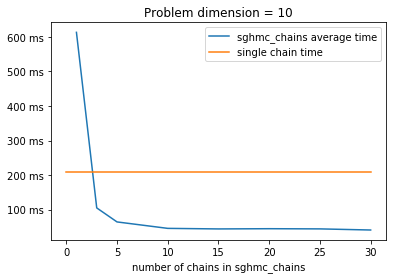

In [16]:
plt.plot(chainNums,np.array(avg_time)*1000,label='sghmc_chains average time')
plt.plot([0,30],[single_time*1000,single_time*1000],label='single chain time')
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ms'))
plt.xlabel('number of chains in sghmc_chains')
plt.title('Problem dimension = 10')
plt.savefig('mpt1.png')

### dnorm=100, dsize=10000

In [17]:
dnorm=100
dsize=10000
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(dsize,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=500

In [18]:
import timeit
chainNums=[1,3,5,10,15,20,25,30]
avg_time=[]
vardict = {'sghmc_chains':sghmc_chains,
           'sghmc':sghmc,
         'grad_log_den_data_jit':grad_log_den_data_jit,
        'grad_log_den_prior_jit':grad_log_den_prior_jit,
        'data':data,
        'V_hat':V_hat,
        'eps':eps,
        'theta_0':theta_0,
        'C':C,
        'heatup':heatup,
        'epoches':epoches,
        'batch_size':batch_size}
for n in chainNums:
    s = 'sghmc_chains(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, '+str(n)+')'
    t = timeit.timeit(s,number=1,globals=vardict)
    avg_time.append(t/n)
    
single_time = timeit.timeit('sghmc(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size)',number=1,globals=vardict)

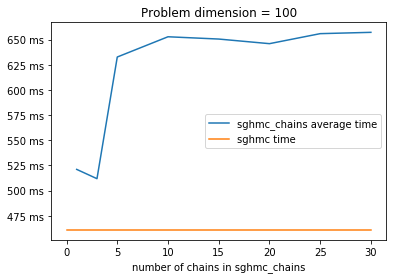

In [19]:
plt.plot(chainNums,np.array(avg_time)*1000,label='sghmc_chains average time')
plt.plot([0,30],[single_time*1000,single_time*1000],label='sghmc time')
plt.legend(loc='best')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ms'))
plt.xlabel('number of chains in sghmc_chains')
plt.title('Problem dimension = 100')
plt.savefig('mpt2.png')